<a href="https://colab.research.google.com/github/KirkDCO/HandsOnML_Exercises/blob/main/Ch17_Q11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp -r drive/MyDrive/Colab\ Notebooks/HandsOnML/Ch17_Q10/flowers sample_data/.

In [ ]:
!mkdir sample_data/flowers_small
!cp -r sample_data/flowers/sunflower sample_data/flowers_small/.

cp: cannot stat 'sample_data/flowers/sunflower': No such file or directory


# Chapter 17 Question 11

Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class.

## Flowers Dataset
...just smaller.

Continuing to use the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers), but reducing it to only sunflowers provides 1027 images of sunflowers.  The images are 96 x 96 RGB images, but I reduced them to 48 x 48.  After some experimentation, the 96 x 96 images did not perform well, but the 48 x 48 seemed better behaved.  

In [3]:
!mkdir sample_data/flowers_small
!cp -r drive/MyDrive/Colab\ Notebooks/HandsOnML/Ch17_Q10/flowers/sunflower sample_data/flowers_small/.

First step is to import needed packages and set up global variables, and create a generator for the flower images.


In [9]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

BATCH_SIZE = 32 

IMG_WIDTH  = 48 
IMG_HEIGHT = 48 

KERNEL_SIZE = 4
ENCODING_SIZE = 32 

In [10]:
# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers_small",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None,
  color_mode = 'rgb'
)

training_generator = training_generator.prefetch(1)

Found 1027 files belonging to 1 classes.


# GAN

The GAN is based on the one presented in the book, but with a few modifications.

* The generator and discriminator have been adjusted for RGB images.
* Four convolutional layers are used, and the number of filters increases from 32 to 64 to 128.  I experimented with up to 4 convolutional layers and with more or less filters, but this seemed to produce the most reasonable results.
* Batch normalization was added to the discriminator and the results were very poor, so the final model has this removed.
* Dropout in the discriminator is critical.  Without it, the discriminator has a very hard time keeping pace with the generator.
* ReLU activations were tried in the generator, but generally produced very poor results.  SeLU performed well.
* A few experiments were done in which additional dense layers were added to the discriminator but these led to poorer results.
* The size of the encodings seemed to be very sensitive to the depth of the network and the size of the images. 

The interdependence of various hyperparameters made it very difficult to find a good balance witin the network.

In [11]:
generator = keras.Sequential([
  keras.layers.Dense(256 * 6 * 6, activation = "selu", input_shape = [ENCODING_SIZE]),
  keras.layers.Reshape([6, 6, 256]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 128, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 64, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 32, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.Conv2DTranspose(filters = 3, kernel_size = KERNEL_SIZE, strides = 1,
                               padding = 'same', activation = 'sigmoid')
])
generator.summary()   

discriminator = keras.Sequential([
  keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = KERNEL_SIZE, 
                      strides = 1, padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(64, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(128, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(256, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation = 'sigmoid')                                  
])
discriminator.summary()

gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9216)              304128    
                                                                 
 reshape (Reshape)           (None, 6, 6, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 128)      512       
 hNormalization)                                                 
                                                        

# Utility Functions

Some utility functions from the book were used with some modifications.

* Exponential decay of the learning rate was added.  When this wasn't present, the generated images would become more sunflower like and then quickly diverge away and then eventually become more sunflower like in later epochs.  This oscillatory behavior was largely controlled with a very small learning rate (which led to incredibly slow training) or exponential decay.
* In the _train_gain_ function, I added two accumulators with the actual image classes and the predicted classes from the discriminator.  This allowed me to add a confusion matrix and accuracy metric after each epoch to see how the discriminator performed.  This was very helpful to see when the discriminator was very poor and thus not providing good feedback to the generator.  
* A plotting option was added to allow showing examples of generated and actual sunflower every so often. 

In [12]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def exponential_decay_fn(learning_rate, epoch):
  return learning_rate * 0.1 ** (epoch / 50)

def train_gan(gan, dataset, BATCH_SIZE, ENCODING_SIZE, n_epochs = 50, plot_frequency = 10, learning_rate = 0.01):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        preds = []
        actuals = []
        for X_batch in dataset:
          # give some feedback during the epoch
          print("=", end = '')
          X_batch /= 255

          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * len(X_batch) + [[1.]] * len(X_batch))
          y1 += 0.05 * tf.random.uniform(tf.shape(y1)) # add random noise to labels
          discriminator.trainable = True
          # K.set_value(discriminator.optimizer.learning_rate, 
          #             exponential_decay_fn(learning_rate, epoch))
          discriminator.train_on_batch(X_fake_and_real, y1)

          # capture the actual and predicted values for later
          actuals.extend([y.numpy()[0] for y in y1])
          preds.extend([y[0] for y in discriminator.predict(X_fake_and_real).tolist()])
          
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          y2 = tf.constant([[1.]] * len(X_batch))
          discriminator.trainable = False
          # K.set_value(gan.optimizer.learning_rate, 
          #             exponential_decay_fn(learning_rate, epoch))
          gan.train_on_batch(noise, y2)

        # print out a confusion matrix to see how the discriminator is doing
        print()
        print(confusion_matrix([1 if a > 0.5 else 0 for a in actuals], 
                               [1 if p > 0.5 else 0 for p in preds]))
        print('accuracy: ', accuracy_score([1 if a > 0.5 else 0 for a in actuals], 
                                           [1 if p > 0.5 else 0 for p in preds]))

        # only plot every 10 epochs
        if epoch % plot_frequency == 0:
          plot_multiple_images(X_fake_and_real, 3)
          plt.show()
          
    plot_multiple_images(X_fake_and_real, 3)
    plt.show()

Epoch 1/250
[[590 437]
 [248 779]]
accuracy:  0.6665043816942551


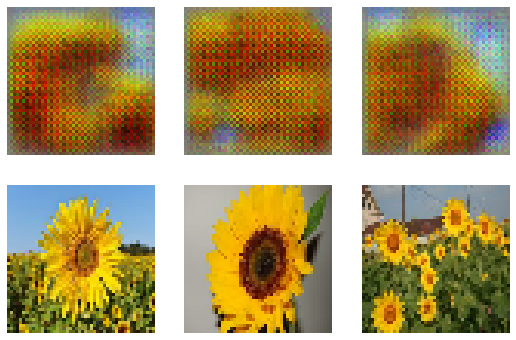

Epoch 2/250
[[454 573]
 [225 802]]
accuracy:  0.611489776046738
Epoch 3/250
[[400 627]
 [283 744]]
accuracy:  0.5569620253164557
Epoch 4/250
[[318 709]
 [224 803]]
accuracy:  0.5457643622200584
Epoch 5/250
[[281 746]
 [183 844]]
accuracy:  0.547711781888997
Epoch 6/250
[[185 842]
 [102 925]]
accuracy:  0.5404089581304771
Epoch 7/250
[[300 727]
 [101 926]]
accuracy:  0.5968841285296982
Epoch 8/250
[[274 753]
 [153 874]]
accuracy:  0.5589094449853943
Epoch 9/250
[[400 627]
 [176 851]]
accuracy:  0.6090555014605648
Epoch 10/250
[[520 507]
 [188 839]]
accuracy:  0.6616358325219085
Epoch 11/250
[[468 559]
 [251 776]]
accuracy:  0.6056475170399221
Epoch 12/250
[[422 605]
 [263 764]]
accuracy:  0.5774099318403116
Epoch 13/250
[[361 666]
 [120 907]]
accuracy:  0.617332035053554
Epoch 14/250
[[355 672]
 [166 861]]
accuracy:  0.5920155793573515
Epoch 15/250
[[543 484]
 [173 854]]
accuracy:  0.6801363193768257
Epoch 16/250
[[567 460]
 [214 813]]
accuracy:  0.6718597857838364
Epoch 17/250
[[609 41

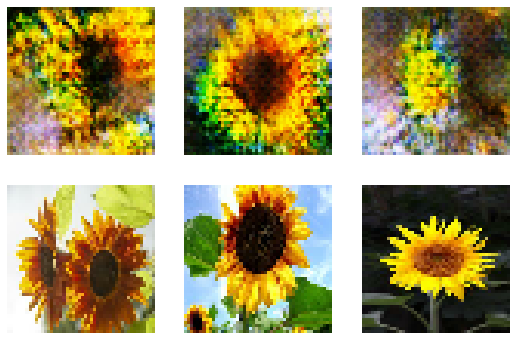

Epoch 27/250
[[754 273]
 [259 768]]
accuracy:  0.7409931840311588
Epoch 28/250
[[800 227]
 [249 778]]
accuracy:  0.7682570593963
Epoch 29/250
[[807 220]
 [184 843]]
accuracy:  0.8033106134371957
Epoch 30/250
[[809 218]
 [273 754]]
accuracy:  0.76095423563778
Epoch 31/250
[[798 229]
 [264 763]]
accuracy:  0.7599805258033107
Epoch 32/250
[[825 202]
 [281 746]]
accuracy:  0.7648490749756572
Epoch 33/250
[[858 169]
 [275 752]]
accuracy:  0.7838364167478091
Epoch 34/250
[[873 154]
 [252 775]]
accuracy:  0.8023369036027264
Epoch 35/250
[[858 169]
 [213 814]]
accuracy:  0.8140214216163584
Epoch 36/250
[[838 189]
 [230 797]]
accuracy:  0.7960077896786758
Epoch 37/250
[[872 155]
 [210 817]]
accuracy:  0.8222979552093476
Epoch 38/250
[[879 148]
 [227 800]]
accuracy:  0.817429406037001
Epoch 39/250
[[880 147]
 [243 784]]
accuracy:  0.810126582278481
Epoch 40/250
[[874 153]
 [213 814]]
accuracy:  0.8218111002921129
Epoch 41/250
[[902 125]
 [162 865]]
accuracy:  0.8602726387536515
Epoch 42/250
[[84

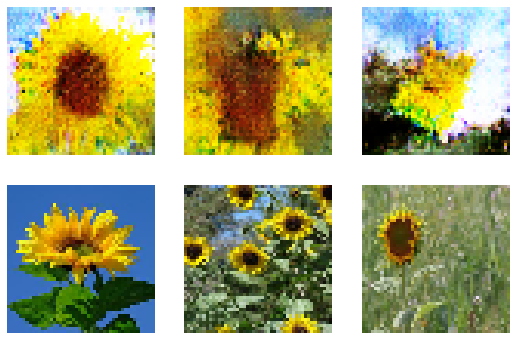

Epoch 52/250
[[910 117]
 [121 906]]
accuracy:  0.8841285296981499
Epoch 53/250
[[933  94]
 [138 889]]
accuracy:  0.887049659201558
Epoch 54/250
[[916 111]
 [135 892]]
accuracy:  0.8802336903602727
Epoch 55/250
[[956  71]
 [130 897]]
accuracy:  0.9021421616358325
Epoch 56/250
[[939  88]
 [136 891]]
accuracy:  0.8909444985394352
Epoch 57/250
[[923 104]
 [134 893]]
accuracy:  0.8841285296981499
Epoch 58/250
[[935  92]
 [119 908]]
accuracy:  0.8972736124634859
Epoch 59/250
[[922 105]
 [136 891]]
accuracy:  0.882667964946446
Epoch 60/250
[[940  87]
 [125 902]]
accuracy:  0.8967867575462513
Epoch 61/250
[[910 117]
 [108 919]]
accuracy:  0.8904576436222006
Epoch 62/250
[[947  80]
 [109 918]]
accuracy:  0.9079844206426485
Epoch 63/250
[[945  82]
 [ 86 941]]
accuracy:  0.9182083739045764
Epoch 64/250
[[934  93]
 [116 911]]
accuracy:  0.8982473222979552
Epoch 65/250
[[906 121]
 [104 923]]
accuracy:  0.8904576436222006
Epoch 66/250
[[963  64]
 [ 77 950]]
accuracy:  0.9313534566699123
Epoch 67/250

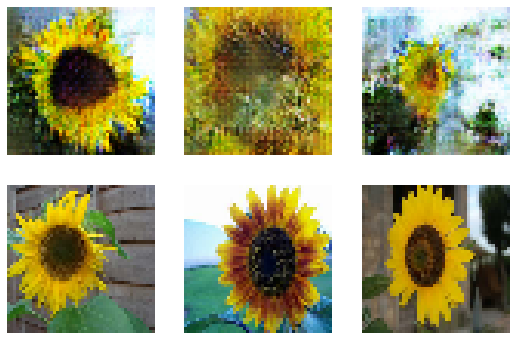

Epoch 77/250
[[978  49]
 [ 48 979]]
accuracy:  0.9527750730282376
Epoch 78/250
[[978  49]
 [ 73 954]]
accuracy:  0.9406037000973709
Epoch 79/250
[[989  38]
 [ 70 957]]
accuracy:  0.9474196689386563
Epoch 80/250
[[972  55]
 [ 74 953]]
accuracy:  0.9371957156767283
Epoch 81/250
[[946  81]
 [ 76 951]]
accuracy:  0.9235637779941578
Epoch 82/250
[[1005   22]
 [  37  990]]
accuracy:  0.9712755598831548
Epoch 83/250
[[963  64]
 [ 44 983]]
accuracy:  0.9474196689386563
Epoch 84/250
[[979  48]
 [ 55 972]]
accuracy:  0.9498539435248295
Epoch 85/250
[[969  58]
 [ 64 963]]
accuracy:  0.9406037000973709
Epoch 86/250
[[979  48]
 [ 47 980]]
accuracy:  0.9537487828627069
Epoch 87/250
[[998  29]
 [ 39 988]]
accuracy:  0.9668938656280428
Epoch 88/250
[[972  55]
 [ 54 973]]
accuracy:  0.9469328140214216
Epoch 89/250
[[967  60]
 [ 53 974]]
accuracy:  0.944985394352483
Epoch 90/250
[[996  31]
 [ 37 990]]
accuracy:  0.9668938656280428
Epoch 91/250
[[947  80]
 [ 58 969]]
accuracy:  0.9328140214216164
Epoch 9

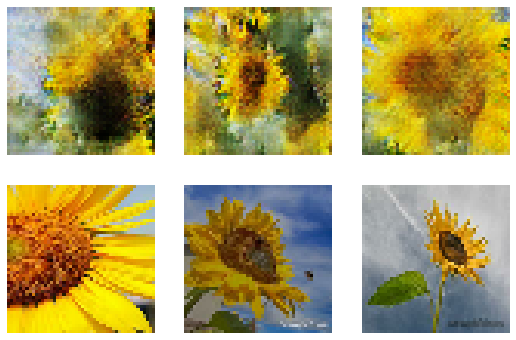

Epoch 102/250
[[966  61]
 [ 38 989]]
accuracy:  0.9518013631937683
Epoch 103/250
[[1002   25]
 [  25 1002]]
accuracy:  0.9756572541382668
Epoch 104/250
[[ 987   40]
 [  26 1001]]
accuracy:  0.9678675754625121
Epoch 105/250
[[987  40]
 [ 36 991]]
accuracy:  0.9629990262901655
Epoch 106/250
[[ 993   34]
 [  13 1014]]
accuracy:  0.9771178188899707
Epoch 107/250
[[ 976   51]
 [  27 1000]]
accuracy:  0.9620253164556962
Epoch 108/250
[[ 995   32]
 [  27 1000]]
accuracy:  0.9712755598831548
Epoch 109/250
[[ 995   32]
 [  20 1007]]
accuracy:  0.9746835443037974
Epoch 110/250
[[987  40]
 [ 29 998]]
accuracy:  0.9664070107108081
Epoch 111/250
[[ 972   55]
 [  24 1003]]
accuracy:  0.9615384615384616
Epoch 112/250
[[ 981   46]
 [  21 1006]]
accuracy:  0.9673807205452775
Epoch 113/250
[[998  29]
 [ 44 983]]
accuracy:  0.9644595910418695
Epoch 114/250
[[996  31]
 [ 28 999]]
accuracy:  0.9712755598831548
Epoch 115/250
[[1000   27]
 [  14 1013]]
accuracy:  0.9800389483933788
Epoch 116/250
[[981  46]
 

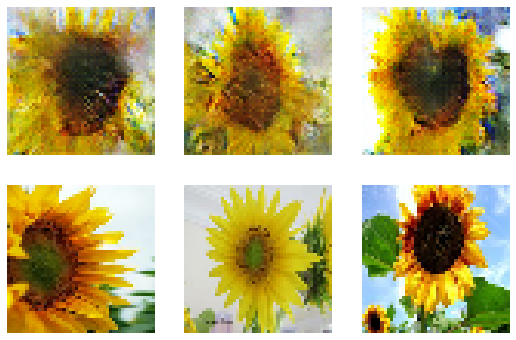

Epoch 127/250
[[ 998   29]
 [  21 1006]]
accuracy:  0.9756572541382668
Epoch 128/250
[[1001   26]
 [  28  999]]
accuracy:  0.9737098344693281
Epoch 129/250
[[ 988   39]
 [  17 1010]]
accuracy:  0.9727361246348588
Epoch 130/250
[[ 997   30]
 [  26 1001]]
accuracy:  0.9727361246348588
Epoch 131/250
[[ 989   38]
 [  18 1009]]
accuracy:  0.9727361246348588
Epoch 132/250
[[1007   20]
 [  15 1012]]
accuracy:  0.9829600778967867
Epoch 133/250
[[ 986   41]
 [  17 1010]]
accuracy:  0.9717624148003895
Epoch 134/250
[[ 988   39]
 [  19 1008]]
accuracy:  0.9717624148003895
Epoch 135/250
[[1007   20]
 [  22 1005]]
accuracy:  0.9795520934761441
Epoch 136/250
[[ 970   57]
 [  22 1005]]
accuracy:  0.9615384615384616
Epoch 137/250
[[1004   23]
 [  13 1014]]
accuracy:  0.9824732229795521
Epoch 138/250
[[ 998   29]
 [  13 1014]]
accuracy:  0.9795520934761441
Epoch 139/250
[[991  36]
 [ 28 999]]
accuracy:  0.9688412852969815
Epoch 140/250
[[ 988   39]
 [  22 1005]]
accuracy:  0.9703018500486855
Epoch 141/

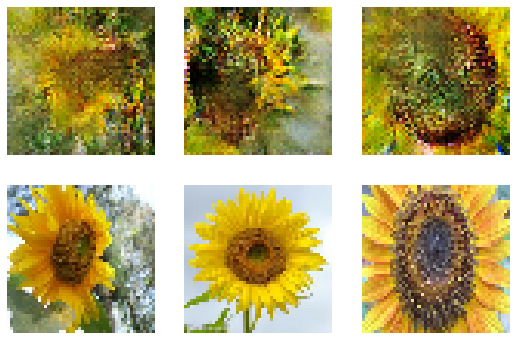

Epoch 152/250
[[1009   18]
 [  17 1010]]
accuracy:  0.9829600778967867
Epoch 153/250
[[ 998   29]
 [  12 1015]]
accuracy:  0.9800389483933788
Epoch 154/250
[[ 995   32]
 [  25 1002]]
accuracy:  0.9722492697176242
Epoch 155/250
[[ 986   41]
 [   9 1018]]
accuracy:  0.9756572541382668
Epoch 156/250
[[1018    9]
 [  12 1015]]
accuracy:  0.9897760467380721
Epoch 157/250
[[1005   22]
 [  17 1010]]
accuracy:  0.9810126582278481
Epoch 158/250
[[1007   20]
 [  23 1004]]
accuracy:  0.9790652385589095
Epoch 159/250
[[ 997   30]
 [  16 1011]]
accuracy:  0.9776046738072055
Epoch 160/250
[[1001   26]
 [  11 1016]]
accuracy:  0.9819863680623174
Epoch 161/250
[[990  37]
 [ 28 999]]
accuracy:  0.9683544303797469
Epoch 162/250
[[1020    7]
 [   8 1019]]
accuracy:  0.99269717624148
Epoch 163/250
[[1002   25]
 [  14 1013]]
accuracy:  0.9810126582278481
Epoch 164/250
[[ 997   30]
 [  26 1001]]
accuracy:  0.9727361246348588
Epoch 165/250
[[1012   15]
 [   8 1019]]
accuracy:  0.9888023369036028
Epoch 166/25

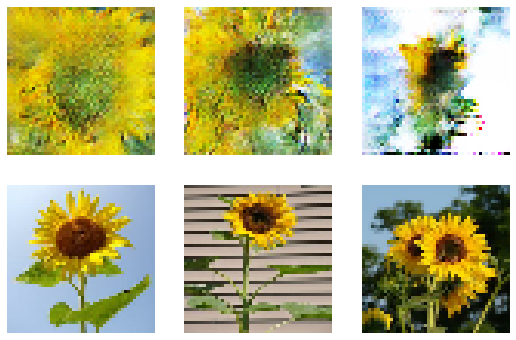

Epoch 177/250
[[ 999   28]
 [  15 1012]]
accuracy:  0.9790652385589095
Epoch 178/250
[[ 995   32]
 [  11 1016]]
accuracy:  0.9790652385589095
Epoch 179/250
[[ 995   32]
 [  11 1016]]
accuracy:  0.9790652385589095
Epoch 180/250
[[ 990   37]
 [  16 1011]]
accuracy:  0.9741966893865628
Epoch 181/250
[[ 990   37]
 [   7 1020]]
accuracy:  0.9785783836416748
Epoch 182/250
[[1008   19]
 [   9 1018]]
accuracy:  0.9863680623174295
Epoch 183/250
[[ 996   31]
 [  11 1016]]
accuracy:  0.9795520934761441
Epoch 184/250
[[ 999   28]
 [  13 1014]]
accuracy:  0.9800389483933788
Epoch 185/250
[[1011   16]
 [  14 1013]]
accuracy:  0.98539435248296
Epoch 186/250
[[1013   14]
 [   6 1021]]
accuracy:  0.9902629016553067
Epoch 187/250
[[ 993   34]
 [  18 1009]]
accuracy:  0.9746835443037974
Epoch 188/250
[[1013   14]
 [   2 1025]]
accuracy:  0.9922103213242454
Epoch 189/250
[[ 999   28]
 [  12 1015]]
accuracy:  0.9805258033106135
Epoch 190/250
[[1016   11]
 [  10 1017]]
accuracy:  0.9897760467380721
Epoch 19

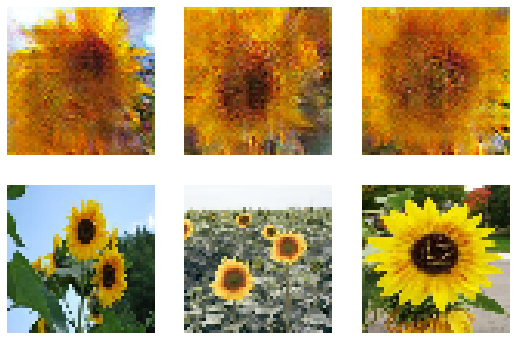

Epoch 202/250
[[1004   23]
 [  16 1011]]
accuracy:  0.9810126582278481
Epoch 203/250
[[1004   23]
 [   8 1019]]
accuracy:  0.9849074975657254
Epoch 204/250
[[1001   26]
 [   6 1021]]
accuracy:  0.9844206426484907
Epoch 205/250
[[1004   23]
 [   5 1022]]
accuracy:  0.9863680623174295
Epoch 206/250
[[1000   27]
 [   6 1021]]
accuracy:  0.9839337877312561
Epoch 207/250
[[ 994   33]
 [   9 1018]]
accuracy:  0.9795520934761441
Epoch 208/250
[[1006   21]
 [   5 1022]]
accuracy:  0.9873417721518988
Epoch 209/250
[[ 998   29]
 [  22 1005]]
accuracy:  0.9751703992210321
Epoch 210/250
[[1018    9]
 [   3 1024]]
accuracy:  0.994157740993184
Epoch 211/250
[[1003   24]
 [   4 1023]]
accuracy:  0.9863680623174295
Epoch 212/250
[[1006   21]
 [   9 1018]]
accuracy:  0.98539435248296
Epoch 213/250
[[1008   19]
 [  15 1012]]
accuracy:  0.9834469328140214
Epoch 214/250
[[1004   23]
 [  15 1012]]
accuracy:  0.9814995131450828
Epoch 215/250
[[ 985   42]
 [  16 1011]]
accuracy:  0.9717624148003895
Epoch 216

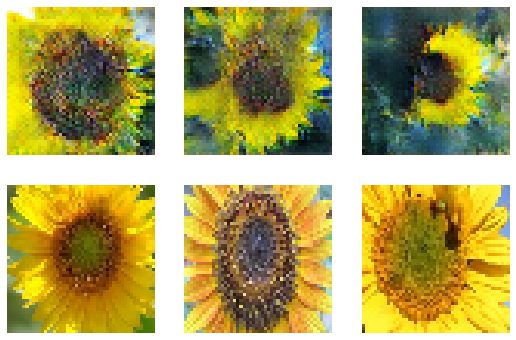

Epoch 227/250
[[1005   22]
 [   9 1018]]
accuracy:  0.9849074975657254
Epoch 228/250
[[1017   10]
 [   2 1025]]
accuracy:  0.994157740993184
Epoch 229/250
[[1002   25]
 [   5 1022]]
accuracy:  0.98539435248296
Epoch 230/250
[[1005   22]
 [  21 1006]]
accuracy:  0.9790652385589095
Epoch 231/250
[[1010   17]
 [   8 1019]]
accuracy:  0.9878286270691334
Epoch 232/250
[[1010   17]
 [   5 1022]]
accuracy:  0.9892891918208374
Epoch 233/250
[[1014   13]
 [   7 1020]]
accuracy:  0.9902629016553067
Epoch 234/250
[[1003   24]
 [   8 1019]]
accuracy:  0.9844206426484907
Epoch 235/250
[[1009   18]
 [   4 1023]]
accuracy:  0.9892891918208374
Epoch 236/250
[[1010   17]
 [   3 1024]]
accuracy:  0.9902629016553067
Epoch 237/250
[[1000   27]
 [  10 1017]]
accuracy:  0.9819863680623174
Epoch 238/250
[[ 999   28]
 [   8 1019]]
accuracy:  0.9824732229795521
Epoch 239/250
[[1012   15]
 [   8 1019]]
accuracy:  0.9888023369036028
Epoch 240/250
[[1004   23]
 [   3 1024]]
accuracy:  0.9873417721518988
Epoch 241

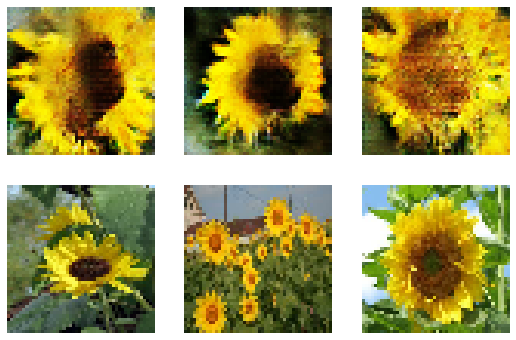

In [13]:
# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(303)

discriminator.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())

train_gan(gan, training_generator, BATCH_SIZE, ENCODING_SIZE, n_epochs = 250, plot_frequency = 25)

# TODO

* figure out learning rate decay options
* more complex network?  
*Compare to https://github.com/MILIND-RAJ/Face-Generation-Using-Generative-Adversarial-Network-GAN-/blob/main/Face_Generation_Using_GAN.ipynb

# Conclusions

In early epochs, the generator essentially learns the color palette first.  In some examples, depending on the size of the images, the depth of the network, etc., the first few epoch were clearly noise in the wrong color space, but would quickly change to the right set of yellows and reds.  Within a few more epochs, a color separation in the images with blue on top, yellow in the middle, and darker (generally greenish) on the bottom, showing that the generator was learing the general structure of the images.  Along the way, more circular shapes would begin to emerge, and eventually some images that had some sunflower characteristics were produced.  Granted, these will not fool anyone, but there's clearly a learning process happening.

It was clear that larger images were much harder, and reducing the images to 48 x 48 helped.  Reducing the images further was helpful, but then the real images were themselves less convincing.  

Deeper network with 4 or 5 convolutional layers and as many as 1024 filters in the deepest layer also improved the images, but only slightly.

Clear limitations of this approach include:
* there were only 1027 images in the real image set
* the images were not very consistently framed - some have wonderfully centered flowers, but there are many camera angles, and many images of fields of sunflowers
* much larger and more complex networks might help, but more training data will probably be more impactful

Also interesting is the periodicity observed in the generated images.  There are repeated pattern blocks that are clearly reflective of the underlying network structure and weights.  I'm quite surprised at the degree of periodicity, however.  A more thorough investigation of the weights of each layer of the network would be interesting to determine why there are such periodic or symmetric structures.